# Dream Challenge Model Prototye

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

In [ ]:
import synapseclient 
import synapseutils 

syn = synapseclient.Synapse() 
syn.login('yztxwd@gmail.com','9zqqW9Jy5QhRFeS') 
synapseutils.syncFromSynapse(syn, 'syn30026233', './data/')
synapseutils.syncFromSynapse(syn, 'syn28469146', './data/')

In [6]:
train_dataset = pd.read_table("./data/train_sequences.txt", header=None, sep="\t")

## Save dataset 

In [7]:
from sklearn.model_selection import train_test_split

df_full = pd.read_table('./data/train_sequences.txt', header=None, names=['seq', 'target'], dtype={'seq':str, 'target':np.float32})
df_train, df_remain = train_test_split(df_full, test_size=0.2, random_state=1)
df_val, df_test = train_test_split(df_remain, test_size=0.5, random_state=1)

In [ ]:
dataset_train = DreamChallengeDataset(df_train.reset_index(), transform=DNA2OneHot())
dataset_val = DreamChallengeDataset(df_val.reset_index(), transform=DNA2OneHot())
dataset_test = DreamChallengeDataset(df_test.reset_index(), transform=DNA2OneHot())

In [ ]:
df_val.reset_index()

,index,seq,target
0,4105474,TGCATTTTTTTCACATCTGCACATTTGATGTTCCTACCACGCGCTA...,15.000000
1,4654389,TGCATTTTTTTCACATCGATAGTTGGTTGGATTTTACCGTTGATAG...,11.000000
2,2266084,TGCATTTTTTTCACATCTCTGTAGGGTTCATCACCTGTTTTATGGG...,8.490439
3,5141768,TGCATTTTTTTCACATCGCTGTGCCTTGCGCATGCTTGGGGTGTAT...,13.000000
4,5849166,TGCATTTTTTTCACATCAATGATTCGCCTAGCTCGATTGTTTATGC...,9.000000
...,...,...,...
673921,4269572,TGCATTTTTTTCACATCATTAATGTGGCCCCCGTATCCATATAGTT...,12.000000
673922,2416930,TGCATTTTTTTCACATCCGGAGACCGATTGTTGGATCCTAGAAGCA...,13.242847
673923,5680606,TGCATTTTTTTCACATCTAATTTGAAGTTTATTTGTCACATATTCT...,8.000000
673924,4536704,TGCATTTTTTTCACATCTTCCGGCGCGCATGATCGGTCTAATGTAA...,12.000000


### TFRecord

In [ ]:
import tfrecord

def get_data_TFRecord_worker(dataset, outprefix):

    TFRecord_file = outprefix + ".TFRecord"
    writer = tfrecord.TFRecordWriter(TFRecord_file)
    count = 0
    for idx, (seq, target) in enumerate(dataset):
        writer.write({'seq': (list(seq.flatten()), 'float'),
                        'target': (target[0], 'float')})
        count += 1
        if count % 100000 == 0: print(f"{count} written")
    writer.close()

In [ ]:
#get_data_TFRecord_worker(dataset_train, "train")
#get_data_TFRecord_worker(dataset_val, "val")
#get_data_TFRecord_worker(dataset_test, "test")

### webdataset

In [ ]:
import webdataset as wds

In [87]:
dataset_train = DreamChallengeDataset(df_train.reset_index(), transform=DNA2OneHot())
dataset_val = DreamChallengeDataset(df_val.reset_index(), transform=DNA2OneHot())
dataset_test = DreamChallengeDataset(df_test.reset_index(), transform=DNA2OneHot())

In [95]:
def writeWDS(dataset, prefix):
    sink = wds.ShardWriter("./shards/" + prefix + "-%02d.tar", maxcount=10000)
    count = 0
    for idx, (seq, target) in enumerate(dataset):
        sink.write({
            '__key__': 'sample%06d' % idx,
            'seq.npy': seq,
            'target.npy': target
        })
        count += 1
        if count % 100000 == 0: print(f"{count} written")
    sink.close()

In [ ]:
writeWDS(dataset_train, "train")

In [ ]:
writeWDS(dataset_val, "val")

In [ ]:
writeWDS(dataset_test, "test")

In [ ]:
df_predict = pd.read_table("./data/test_sequences.txt", header=None, names=['seq', 'target'], dtype={'seq':str, 'target':np.float32})
dataset_predict = DreamChallengeDataset(df_predict, transform=DNA2OneHot())

In [ ]:
writeWDS(dataset_predict, "pred")

## DataLoader

In [2]:
%%writefile dataloader.py

# lightning data module
import os
import io
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.utilities import cli as pl_cli
from torch.utils.data import random_split, DataLoader

import webdataset as wds

class DNA2OneHot(object):
    def __init__(self, expect_len=110, rev=False):
        self.expect_len = expect_len
        self.rev = rev
        self.DNA2Index = {
            "A": 0,
            "C": 1,
            "G": 2,
            "T": 3
        }
    
    def __call__(self, dnaSeq):
        # initialize the matrix as 4 x self.expect_len
        seqMatrixs = np.zeros((4, self.expect_len), dtype=np.float32)
        # change the value to matrix
        seqLen = len(dnaSeq)
        dnaSeq = self.rev_comp(dnaSeq.upper()) if self.rev else dnaSeq.upper()
        for j in range(0, min(seqLen, self.expect_len)):
            try:
                seqMatrixs[self.DNA2Index[dnaSeq[j]], j] = 1
            except KeyError as e:
                continue
        return seqMatrixs

class DreamChallengeDataset(Dataset):
    def __init__(self, df=None, transform=None, target_transform=None):
        self.seq = df.seq
        self.target = df.target
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.seq)
    
    def __getitem__(self, idx):
        seq = self.seq.iloc[idx]
        target = self.target.iloc[idx][np.newaxis]
        if self.transform:
            seq = self.transform(seq)
        if self.target_transform:
            target = self.target_transform(target)
        return seq, target

    def rev_comp(self, inp_str):
        rc_dict = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'c': 'g',
                   'g': 'c', 't': 'a', 'a': 't', 'n': 'n', 'N': 'N'}
        outp_str = list()
        for nucl in inp_str:
            outp_str.append(rc_dict[nucl])
        return ''.join(outp_str)[::-1]    

def npy_decoder(key, value):
    if not key.endswith(".npy"):
        return None
    assert isinstance(value, bytes)
    return np.load(io.BytesIO(value))

def worker_splitter(urls):
    urls = [url for url in urls]
    assert isinstance(urls, list)

    worker_info = torch.utils.data.get_worker_info()
    if worker_info is not None:
        wid = worker_info.id
        num_workers = worker_info.num_workers

        return iter(urls[wid::num_workers])
    else:
        return iter(urls)

def node_splitter(urls):
    urls = [url for url in urls]

    shard_id = torch.distributed.get_rank()
    num_shards = torch.distributed.get_world_size()

    urls_this = urls[shard_id::num_shards]

    return iter(urls_this)

@pl_cli.DATAMODULE_REGISTRY
class DreamChallengeDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str="./shards/", train_epochs=1, batch_size=512, num_workers=6):
        super().__init__()
        self.data_dir = data_dir
        self.transform = DNA2OneHot()
        self.train_epochs = train_epochs
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.description = {"seq": "float", "target": "float"}

        self.dataset_train = None
        self.dataset_val = None
        self.dataset_test = None
        self.dataset_predict = None
    
    def prepare_data(self):
        # Assume data already in self.data_dir
        pass

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            shard_id = torch.distributed.get_rank()
            num_shards = torch.distributed.get_world_size()
            print(f"shard id: {shard_id}, num shards: {num_shards}")

            self.dataset_train = wds.DataPipeline(
                wds.ResampledShards("shards/train-{00..539}.tar"),
                wds.tarfile_to_samples(),
                wds.shuffle(1000),
                wds.decode(npy_decoder),
                wds.shuffle(1000),
                wds.to_tuple("seq.npy", "target.npy"),
                wds.batched(self.batch_size, partial=False)
                ).with_epoch(5391406//self.batch_size//num_shards//self.num_workers)

            self.dataset_val = wds.DataPipeline(
                wds.SimpleShardList("shards/val-{00..67}.tar"),
                node_splitter,
                worker_splitter,
                wds.tarfile_to_samples(),
                wds.decode(npy_decoder),
                wds.to_tuple("seq.npy", "target.npy"),
                wds.batched(self.batch_size, partial=False)
                )
            #.with_length(673926//num_data_instances)

        if stage == "test" or stage is None:
            self.dataset_test = wds.DataPipeline(
                wds.SimpleShardList("shards/test-{00..67}.tar"),
                worker_splitter,
                wds.tarfile_to_samples(),
                wds.decode(npy_decoder),
                wds.to_tuple("seq.npy", "target.npy"),
                wds.batched(self.batch_size, partial=True)
                )
            #.with_length(673926)

        if stage == "predict" or stage is None:
            self.dataset_predict = wds.DataPipeline(
                wds.SimpleShardList("shards/pred-{00..07}.tar"),
                worker_splitter,
                wds.tarfile_to_samples(),
                wds.decode(npy_decoder),
                wds.to_tuple("seq.npy", "target.npy"),
                wds.batched(self.batch_size, partial=True)
            )
        
    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=1, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=1, num_workers=self.num_workers)
        
    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=1, num_workers=1)
    
    def predict_dataloader(self):
        return DataLoader(self.dataset_predict, batch_size=1,)


Overwriting dataloader.py


In [75]:
import webdataset as wds

In [76]:
ds = wds.DataPipeline(
    wds.SimpleShardList("shards/train-{00..539}.tar"),
    wds.tarfile_to_samples(),
    wds.decode(npy_decoder),
    wds.to_tuple("seq.npy", "target.npy"),
    wds.batched(512, partial=False)
).with_epoch(1)

In [84]:
for i in ds: print(i)

[array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 1.]]], dtype=float32), array([[12.270287 ],
 

## Check target distribution

In [ ]:
ds = DreamChallengeDataModule(transform=DNA2OneHot())
ds.setup()

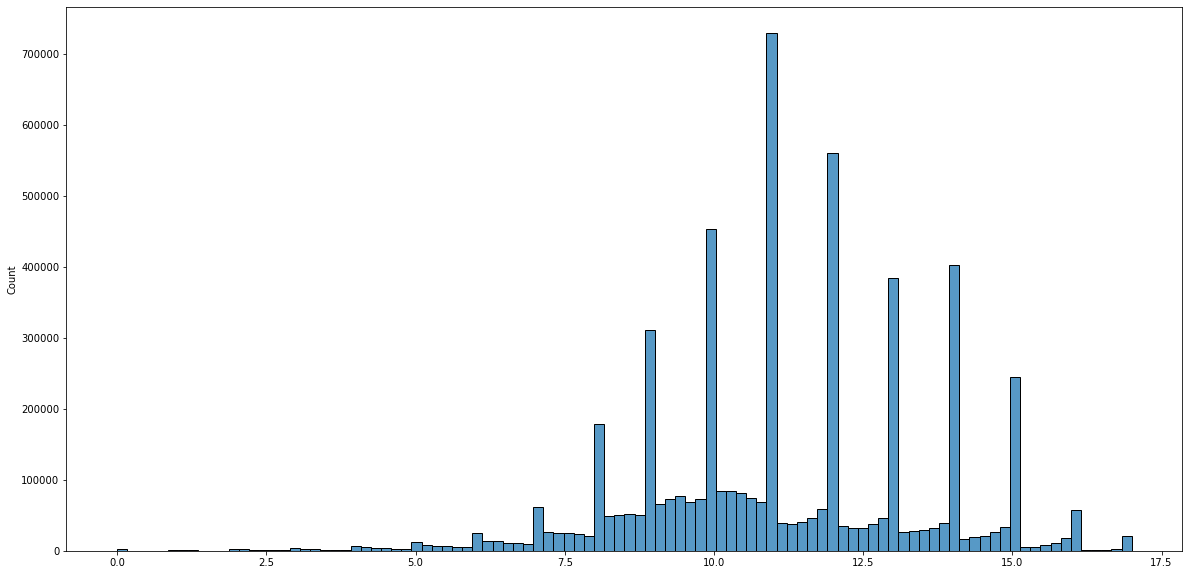

In [ ]:
# train
ds_train = ds.train_dataloader()
targets = []
for seq, target in ds_train:
    targets.append(target)
targets = torch.cat(targets)
# plot histogram on targets
targets.numpy()
fig = plt.figure(figsize=(20, 10))
ax = sns.histplot(x=targets, bins=100)

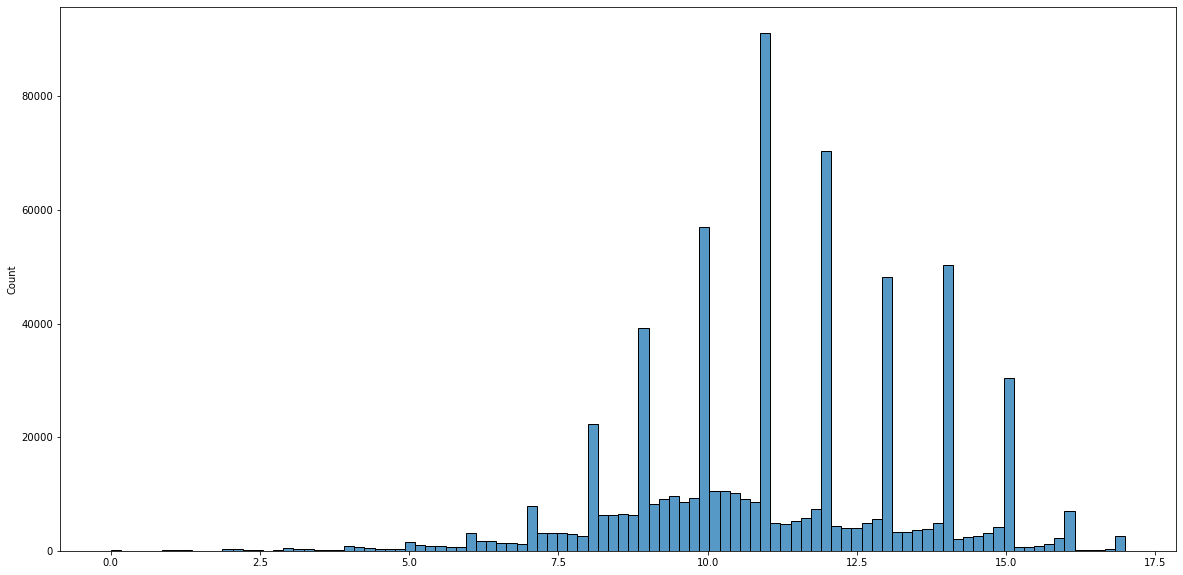

In [ ]:
# val
ds_val = ds.val_dataloader()
targets = []
for seq, target in ds_val:
    targets.append(target)
targets = torch.cat(targets)
# plot histogram on targets
targets.numpy()
fig = plt.figure(figsize=(20, 10))
ax = sns.histplot(x=targets, bins=100)

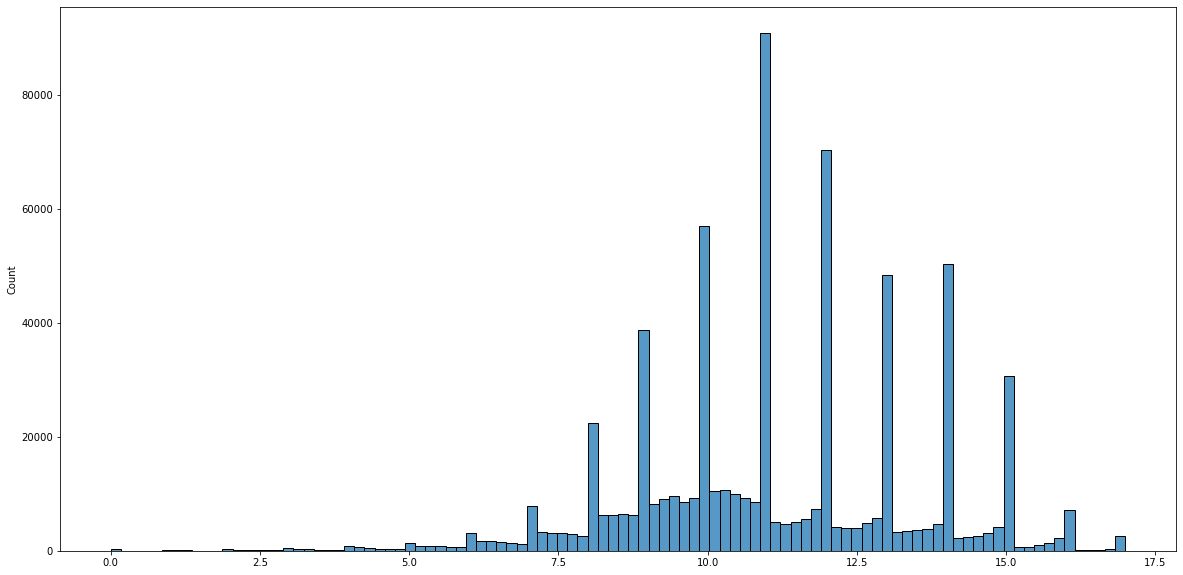

In [ ]:
# test
ds_test = ds.test_dataloader()
targets = []
for seq, target in ds_test:
    targets.append(target)
targets = torch.cat(targets)
# plot histogram on targets
targets.numpy()
fig = plt.figure(figsize=(20, 10))
ax = sns.histplot(x=targets, bins=100)

## Lightning training script

In [9]:
%%writefile lightning_dreamchallenge.py

import os
import subprocess

import numpy as np
from collections import OrderedDict

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from pytorch_lightning.utilities.cli import LightningCLI
from pytorch_lightning.utilities import cli as pl_cli
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy.stats import pearsonr
import pytorch_lightning as pl

from dataloader import DreamChallengeDataModule

class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

class NNHooks(pl.LightningModule):
    def __init__(self):
        super().__init__()

    def training_step(self, batch, batch_idx):
        seq, y = batch
        y_hat = self(seq)
        y = torch.squeeze(y, 0)
        #print(torch.stack([y, y_hat], 1)[:5])

        # compute loss
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        seq, y = batch
        y_hat = self(seq)
        y = torch.squeeze(y, 0)
        #print(torch.stack([y, y_hat], 1)[:5])

        # compute loss
        val_loss = F.mse_loss(y_hat, y)
        self.log('val_loss', val_loss)
        return {'val_loss': val_loss, 'pred': y_hat, 'true': y}

    def test_step(self, batch, batch_idx):
        seq, y = batch
        y_hat = self(seq)
        y = torch.squeeze(y, 0)

        # compute loss
        test_loss = F.mse_loss(y_hat, y)
        self.log('test_loss', test_loss)
        return {'test_loss': test_loss}

    def predict_step(self, batch, batch_idx):
        seq, y = batch
        y_hat = self(seq)

        return y_hat

    def validation_epoch_end(self, test_step_outputs):
        # plot a scatterplot to show correlation between prediction and target
        # collect outputs from each batch
        out_preds = []
        out_trues = []
        out_labels = []
        for outs in test_step_outputs:
            out_preds.append(outs['pred'])
            out_trues.append(outs['true'])
        
        # gather from ddp processes
        out_preds = self.all_gather(torch.stack(out_preds))
        out_trues = self.all_gather(torch.stack(out_trues))

        # plot figure in the main process
        if self.local_rank == 0: 
            out_preds = out_preds.detach().cpu().numpy().flatten()
            out_trues = out_trues.detach().cpu().numpy().flatten()

            fig = plt.figure(figsize=(12, 12))
            ax = sns.scatterplot(x=out_preds, y=out_trues)
            ax.set_xlim(left=0, right=8)
            ax.text(0.1, 0.8, f"pearsonr correlation efficient/p-value \n{pearsonr(out_preds, out_trues)}", transform=plt.gca().transAxes)
            self.logger.experiment.add_figure(f"Prediction vs True on validation dataset after epoch {self.current_epoch}", fig)

    def on_predict_epoch_end(self, predict_step_outputs):
        # collect outputs from each batch
        out_preds = []
        for outs in predict_step_outputs[0]: 
            out_preds.append(outs)
        
        # gather from ddp processes
        out_preds = self.all_gather(torch.cat(out_preds))

        # save
        if self.global_rank == 0:
            np.savetxt(os.path.join(self.logger.log_dir, "model_preds.txt"), out_preds.cpu().numpy().flatten(), fmt="%.6f")
        print(f"Saved model predictions into model_preds.txt")

@pl_cli.MODEL_REGISTRY
class ConvolutionalModel(NNHooks):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        self.model_strand_specific_forward = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.LeakyReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.LeakyReLU()),
            ('batchnorm2', nn.BatchNorm1d(256)),
        ]))
        self.model_strand_specific_reverse = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.LeakyReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.LeakyReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
        ]))
        self.model_body = nn.Sequential(OrderedDict([
            ('conv3', nn.Conv1d(512, 256, 31, padding=15)),
            ('relu3', nn.LeakyReLU()),
            ('batchnorm3', nn.BatchNorm1d(256)),
            ('conv4', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu4', nn.LeakyReLU()),
            ('batchnorm4', nn.BatchNorm1d(256)),
            ('faltten', Flatten()),
            ('dense1', nn.Linear(110*256, 256)),
            ('relu5', nn.LeakyReLU()),
            ('batchnorm5', nn.BatchNorm1d(256)),
            ('dropout1', nn.Dropout(self.dropout)),
            ('dense2', nn.Linear(256, 256)),
            ('relu6', nn.LeakyReLU()),
            ('batchnorm6', nn.BatchNorm1d(256)),
            ('dropout1', nn.Dropout(self.dropout))
        ]))
        self.model_head = nn.Sequential(OrderedDict([
            ('dense_head', nn.Linear(256, 1))
        ]))

    def forward(self, seq):
        seq = torch.squeeze(seq, 0)
        seq_revcomp = torch.flip(seq.detach().clone(), [1, 2])
        y_hat_for = self.model_strand_specific_forward(seq)
        y_hat_rev = self.model_strand_specific_reverse(seq_revcomp)
        y_hat = torch.cat([y_hat_for, y_hat_rev], dim=1)
        y_hat = self.model_body(y_hat)
        y_hat = self.model_head(y_hat)

        return y_hat

@pl_cli.MODEL_REGISTRY
class ConvolutionalModelAdj(NNHooks):
    def __init__(self, dropout=0.5, num_conv=2, dilation=1):
        super().__init__()
        self.num_conv = num_conv
        self.dilation = dilation
        self.dropout = dropout

        self.model_strand_specific_forward = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.LeakyReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.LeakyReLU()),
            ('batchnorm2', nn.BatchNorm1d(256)),
        ]))
        self.model_strand_specific_reverse = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.LeakyReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.LeakyReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
        ]))
        conv_repeat_dict = OrderedDict([])
        for i in range(self.num_conv):
            conv_repeat_dict[f"conv_repeat_{i}"] = nn.Sequential(OrderedDict([
                                                    (f'conv_repeat_{i}', nn.Conv1d(512, 512, 31, padding=15*self.dilation, dilation=self.dilation)),
                                                    (f'relu_repeat_{i}', nn.LeakyReLU()),
                                                    (f'batchnorm_repeat_{i}', nn.BatchNorm1d(512)),
                                                    ]))
        self.model_conv_repeat = nn.Sequential(conv_repeat_dict)
        self.model_body = nn.Sequential(OrderedDict([
            ('faltten', Flatten()),
            ('dense1', nn.Linear(110*512, 256)),
            ('relu5', nn.LeakyReLU()),
            ('batchnorm5', nn.BatchNorm1d(256)),
            ('dropout1', nn.Dropout(self.dropout)),
            ('dense2', nn.Linear(256, 256)),
            ('relu6', nn.LeakyReLU()),
            ('batchnorm6', nn.BatchNorm1d(256)),
            ('dropout1', nn.Dropout(self.dropout))
        ]))
        self.model_head = nn.Sequential(OrderedDict([
            ('dense_head', nn.Linear(256, 1))
        ]))

    def forward(self, seq):
        seq = torch.squeeze(seq, 0)
        seq_revcomp = torch.flip(seq.detach().clone(), [1, 2])
        y_hat_for = self.model_strand_specific_forward(seq)
        y_hat_rev = self.model_strand_specific_reverse(seq_revcomp)
        y_hat = torch.cat([y_hat_for, y_hat_rev], dim=1)
        y_hat = self.model_body(y_hat)
        y_hat = self.model_head(y_hat)

        return y_hat

class MyLightningCLI(LightningCLI):
    def add_arguments_to_parser(self, parser):
        parser.add_optimizer_args(torch.optim.Adam)

    def after_fit(self):
        for cb in self.trainer.callbacks:
            if isinstance(cb, ModelCheckpoint):
                newname = os.path.join(os.path.dirname(cb.best_model_path), os.path.splitext(os.path.basename(cb.best_model_path))[0] + "_best.ckpt")
                subprocess.check_call(["cp", cb.best_model_path, newname])
            break

def main():
    cli = MyLightningCLI(datamodule_class=DreamChallengeDataModule, auto_registry=True, save_config_overwrite=True)

if __name__ == '__main__':
    main()

Overwriting lightning_dreamchallenge.py


In [ ]:
%%writefile native_pytorch.py

import sys
import yaml
from collections import OrderedDict

import torch
import torch_xla
import torch_xla.core.xla_model as xm
from torch import nn
import torchmetrics

from dataloader import DreamChallengeDataModule
from tqdm import tqdm

class ConvolutionalModel(nn.Module):
    def __init__(self):
        super(ConvolutionalModel, self).__init__()

        self.model_strand_specific_forward = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.ReLU())
        ]))
        self.model_strand_specific_reverse = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.ReLU())
        ]))
        self.model_body = nn.Sequential(OrderedDict([
            ('conv3', nn.Conv1d(512, 256, 31, padding=15)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu4', nn.ReLU()),
            ('faltten', nn.Flatten()),
            ('dense1', nn.Linear(110*256, 256)),
            ('relu5', nn.ReLU()),
            ('dropout1', nn.Dropout(0.2)),
            ('dense2', nn.Linear(256, 256)),
            ('relu6', nn.ReLU()),
            ('dropout1', nn.Dropout(0.2))
        ]))
        self.model_head = nn.Sequential(OrderedDict([
            ('dense_head', nn.Linear(256, 1))
        ]))

        self.example_input = torch.zeros(512, 4, 110).index_fill_(1, torch.tensor(2), 1)

    def forward(self, seq):
        seq_revcomp = torch.flip(seq.detach().clone(), [1, 2])
        y_hat_for = self.model_strand_specific_forward(seq)
        y_hat_rev = self.model_strand_specific_reverse(seq_revcomp)
        y_hat = torch.cat([y_hat_for, y_hat_rev], dim=1)
        y_hat = self.model_body(y_hat)
        y_hat = self.model_head(y_hat)

        return y_hat

def train_loop(dataloader, model, loss_fn, optimizer, device):
    model = model.to(device)

    num_batches = len(dataloader)
    pbar = tqdm(enumerate(dataloader))
    for batch, (X, y) in pbar:
        X = X.to(device)
        y = y.to(device)

        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        xm.mark_step()

        pbar.set_description(f"Training loss: {loss:>7f}  [{batch:>5d}/{num_batches:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    model = model.to(device)

    metric = torchmetrics.MeanSquaredError()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            mse = metric(pred, y)

    mse = metric.compute()
    print(f"MSE on all data: {mse}") 

def main():
    # load config
    config = yaml.safe_load(open(sys.argv[1], "r"))

    device = xm.xla_device()
    print(f"XLA device: {device}")

    model = ConvolutionalModel()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["optimizer"]["lr"])

    datamodule = DreamChallengeDataModule(batch_size=config["data"]["init_args"]["batch_size"], num_workers=config["data"]["init_args"]["num_workers"])
    datamodule.setup()

    epochs = 3
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------")
        train_loop(datamodule.train_dataloader(), model.train(), loss_fn, optimizer, device)
        test_loop(datamodule.val_dataloader(), model.eval(), loss_fn, device)
    print("Done!")

if __name__ == '__main__':
    main()


Overwriting native_pytorch.py


## TPU DDP

In [ ]:
%%writefile args_parse.py

# This module cannot import any other PyTorch/XLA module. Only Python core modules.
import argparse
import os
import sys


def parse_common_options(datadir=None,
                         logdir=None,
                         num_cores=None,
                         batch_size=128,
                         num_epochs=10,
                         num_workers=2,
                         log_steps=20,
                         lr=None,
                         momentum=None,
                         target_accuracy=None,
                         profiler_port=9012,
                         opts=None):
  parser = argparse.ArgumentParser(add_help=True)
  parser.add_argument('--datadir', type=str, default=datadir)
  parser.add_argument('--logdir', type=str, default=logdir)
  parser.add_argument('--num_cores', type=int, default=num_cores)
  parser.add_argument('--batch_size', type=int, default=batch_size)
  parser.add_argument('--num_epochs', type=int, default=num_epochs)
  parser.add_argument('--num_workers', type=int, default=num_workers)
  parser.add_argument('--log_steps', type=int, default=log_steps)
  parser.add_argument('--profiler_port', type=int, default=profiler_port)
  parser.add_argument('--lr', type=float, default=lr)
  parser.add_argument('--momentum', type=float, default=momentum)
  parser.add_argument('--target_accuracy', type=float, default=target_accuracy)
  parser.add_argument('--drop_last', action='store_true')
  parser.add_argument('--fake_data', action='store_true')
  parser.add_argument('--tidy', action='store_true')
  parser.add_argument('--metrics_debug', action='store_true')
  parser.add_argument('--async_closures', action='store_true')
  if opts:
    for name, aopts in opts:
      parser.add_argument(name, **aopts)
  args, leftovers = parser.parse_known_args()
  sys.argv = [sys.argv[0]] + leftovers
  # Setup import folders.
  xla_folder = os.path.dirname(os.path.dirname(os.path.abspath(sys.argv[0])))
  sys.path.append(os.path.join(os.path.dirname(xla_folder), 'test'))
  return args

Overwriting args_parse.py


In [ ]:
%%writefile models.py

import torch
import torch.nn as nn
from collections import OrderedDict

class ConvolutionalModel(nn.Module):
    def __init__(self):
        super(ConvolutionalModel, self).__init__()

        self.model_strand_specific_forward = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.ReLU())
        ]))
        self.model_strand_specific_reverse = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.ReLU())
        ]))
        self.model_body = nn.Sequential(OrderedDict([
            ('conv3', nn.Conv1d(512, 256, 31, padding=15)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu4', nn.ReLU()),
            ('faltten', nn.Flatten()),
            ('dense1', nn.Linear(110*256, 256)),
            ('relu5', nn.ReLU()),
            ('dropout1', nn.Dropout(0.2)),
            ('dense2', nn.Linear(256, 256)),
            ('relu6', nn.ReLU()),
            ('dropout1', nn.Dropout(0.2))
        ]))
        self.model_head = nn.Sequential(OrderedDict([
            ('dense_head', nn.Linear(256, 1))
        ]))

        self.example_input = torch.zeros(512, 4, 110).index_fill_(1, torch.tensor(2), 1)

    def forward(self, seq):
        seq_revcomp = torch.flip(seq.detach().clone(), [1, 2])
        y_hat_for = self.model_strand_specific_forward(seq)
        y_hat_rev = self.model_strand_specific_reverse(seq_revcomp)
        y_hat = torch.cat([y_hat_for, y_hat_rev], dim=1)
        y_hat = self.model_body(y_hat)
        y_hat = self.model_head(y_hat)

        return y_hat

class ConvolutionalModelRegular(nn.Module):
    def __init__(self, dropout=0.5):
        super(ConvolutionalModel, self).__init__()
        self.dropout = dropout

        self.model_strand_specific_forward = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.ReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.ReLU())
            ('batchnorm2', nn.BatchNorm1d(256))
        ]))
        self.model_strand_specific_reverse = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(4, 256, 31, padding=15)),
            ('relu1', nn.ReLU()),
            ('batchnorm1', nn.BatchNorm1d(256)),
            ('conv2', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu2', nn.ReLU())
            ('batchnorm2', nn.BatchNorm1d(256))
        ]))
        self.model_body = nn.Sequential(OrderedDict([
            ('conv3', nn.Conv1d(512, 256, 31, padding=15)),
            ('relu3', nn.ReLU()),
            ('batchnorm3', nn.BatchNorm1d(256)),
            ('conv4', nn.Conv1d(256, 256, 31, padding=15)),
            ('relu4', nn.ReLU()),
            ('batchnorm4', nn.BatchNorm1d(256)),
            ('faltten', nn.Flatten()),
            ('dense1', nn.Linear(110*256, 256)),
            ('relu5', nn.ReLU()),
            ('dropout1', nn.Dropout(self.dropout)),
            ('dense2', nn.Linear(256, 256)),
            ('relu6', nn.ReLU()),
            ('dropout1', nn.Dropout(self.dropout))
        ]))
        self.model_head = nn.Sequential(OrderedDict([
            ('dense_head', nn.Linear(256, 1))
        ]))

        self.example_input = torch.zeros(512, 4, 110).index_fill_(1, torch.tensor(2), 1)

    def forward(self, seq):
        seq_revcomp = torch.flip(seq.detach().clone(), [1, 2])
        y_hat_for = self.model_strand_specific_forward(seq)
        y_hat_rev = self.model_strand_specific_reverse(seq_revcomp)
        y_hat = torch.cat([y_hat_for, y_hat_rev], dim=1)
        y_hat = self.model_body(y_hat)
        y_hat = self.model_head(y_hat)

        return y_hat


Overwriting models.py


In [71]:
torch.Tensor(np.arange(10).reshape(2,5))[0,]

tensor([0., 1., 2., 3., 4.])

In [94]:
%%writefile tpu_ddp.py

import args_parse

FLAGS = args_parse.parse_common_options(
    log_steps=200,
    datadir='./shards/',
    logdir='./conv_model/',
    batch_size=512,
    momentum=0.5,
    lr=0.0001,
    num_epochs=100,
    num_workers=32,
    opts=[('--patience', {'type': int, 'default': 5}),
          ('--train_epochs', {'type': int, 'default': None})])

import os
import shutil
import sys
import subprocess
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils
import webdataset as wds
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import DreamChallengeDataModule
from tqdm import tqdm
from torchmetrics import MeanSquaredError

import models

def _train_update(device, x, loss, tracker, writer):
  loss_item = loss.item()
  #test_utils.print_training_update(
  #    device,
  #    x
  #    loss_item,
  #    tracker.rate(),
  #    tracker.global_rate(),
  #    summary_writer=writer)
  test_utils.write_to_summary(
      writer,
      dict_to_write={
        "loss": loss_item
      })

def train_model(flags, **kwargs):
  torch.manual_seed(1)

  print(f"Device {xm.get_ordinal()} in world size of {xm.xrt_world_size()}")
  num_data_instances = xm.xrt_world_size() * flags.num_workers
  train_epochs = flags.train_epochs if flags.train_epochs is not None else 5391406//num_data_instances//flags.batch_size
  datamodule = DreamChallengeDataModule(data_dir=flags.datadir, train_epochs=train_epochs, batch_size=flags.batch_size, num_workers=flags.num_workers)
  datamodule.setup()
  train_loader = datamodule.train_dataloader()
  val_loader = datamodule.val_dataloader()

  # Scale learning rate to num cores
  lr = flags.lr * xm.xrt_world_size()

  model = models.ConvolutionalModel()
  writer = None
  if xm.is_master_ordinal():
    writer = test_utils.get_summary_writer(flags.logdir)
    writer.add_graph(model, model.example_input)
  device = xm.xla_device()
  model = model.to(device)
  #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=flags.momentum)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.MSELoss()

  def train_loop_fn(epoch, loader):
    tracker = xm.RateTracker()
    model.train()
    pbar = tqdm(enumerate(loader))
    for step, (data, target) in pbar:
      data = torch.squeeze(data, 0)
      target = torch.squeeze(target, 0)
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      #xm.optimizer_step(optimizer)
      xm.reduce_gradients(optimizer)
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, error_if_nonfinite=True)
      optimizer.step()
      tracker.add(flags.batch_size)
      if xm.is_master_ordinal():
        pbar.set_description("Loss %s" % loss.item())
        #if step % flags.log_steps == 0:
        #  xm.add_step_closure(
        #    _train_update,
        #    args=(device, step, loss, tracker, writer),
        #    run_async=flags.async_closures
        #  )
    if xm.is_master_ordinal():
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.detach().cpu().numpy()
      }, os.path.join(flags.logdir, f"checkpoint-epoch{epoch}.ckpt"))
      
  def val_loop_fn(loader):
    model.eval()
    metrics = MeanSquaredError()
    pbar = tqdm(enumerate(loader))
    for step, (data, target) in pbar:
      data = torch.squeeze(data, 0)
      target = torch.squeeze(target, 0)
      pred = model(data)
      metrics.update(pred, target)
      if xm.is_master_ordinal(): 
        if step == 0:
          print(torch.stack([target, pred], 1)[:10])

    mse = metrics.compute()  
    mse = xm.mesh_reduce('val_mse', mse, np.mean)
    return mse

  train_device_loader = pl.MpDeviceLoader(train_loader, device)
  val_device_loader = pl.MpDeviceLoader(val_loader, device)
  # Early stopping
  mse, min_mse = 1e3, 1e3
  best_epoch = -1
  patience = FLAGS.patience
  trigger_times = 0
  for epoch in range(1, flags.num_epochs + 1):
    xm.master_print('Epoch {} train begin {}'.format(epoch, test_utils.now()))
    train_loop_fn(epoch, train_device_loader)
    xm.master_print('Epoch {} train end {}'.format(epoch, test_utils.now()))

    mse = val_loop_fn(val_device_loader)
    xm.master_print('Epoch {} end {}, Val MSE={:.2f}'.format(
        epoch, test_utils.now(), mse))
    test_utils.write_to_summary(
        writer,
        epoch,
        dict_to_write={'MSE/val': mse},
        write_xla_metrics=True)
    if flags.metrics_debug:
      xm.master_print(met.metrics_report())

    # Early stopping
    if mse > min_mse:
        trigger_times += 1
        #print('Trigger Times:', trigger_times)
        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break
    else:
        #print('trigger times: 0')
        trigger_times = 0

        min_mse = mse
        best_epoch = epoch

  test_utils.close_summary_writer(writer)
  xm.master_print(f'Min MSE: {min_mse:.2f} from Epoch {best_epoch}')
  if xm.is_master_ordinal(): subprocess.run(['cp', os.path.join(flags.logdir, f"checkpoint-epoch{best_epoch}.ckpt"), os.path.join(flags.logdir, f"checkpoint-epoch{best_epoch}-best.ckpt")], shell=True)

  return min_mse, best_epoch
  
def _mp_fn(index, flags):
  torch.set_default_tensor_type('torch.FloatTensor')
  mse, best_epoch = train_model(flags)
  if flags.tidy and os.path.isdir(flags.datadir):
    shutil.rmtree(flags.datadir)

if __name__ == '__main__':
  xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS.num_cores)

Overwriting tpu_ddp.py


In [4]:
import webdataset as wds
import io
import numpy as np

def npy_decoder(key, value):
    if not key.endswith(".npy"):
        return None
    assert isinstance(value, bytes)
    return np.load(io.BytesIO(value))

dataset_train = wds.DataPipeline(
    wds.ResampledShards("shards/train-{00..539}.tar"),
    #node_splitter,
    #worker_splitter,
    wds.tarfile_to_samples(),
    wds.decode(npy_decoder),
    wds.to_tuple("seq.npy", "target.npy"),
    wds.batched(512, partial=False)
    )

In [12]:
for seq, target in dataset_train: break
seq = torch.Tensor(seq)
target = torch.Tensor(target)

In [16]:
import models

model = models.ConvolutionalModel()
model = model.cpu()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

model.train()
for i in range(1000):
    optimizer.zero_grad()
    pred = model(seq)
    loss = loss_fn(pred, target)
    print(loss.item())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5, error_if_nonfinite=True)
    optimizer.step()

## Test model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import models

/home/jmy5455/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
import importlib
importlib.reload(models)

<module 'models' from '/home/jmy5455/models.py'>

In [49]:
import torch_xla.core.xla_model as xm
model = models.ConvolutionalModel()
device = xm.xla_device()
model = model.to(device)

checkpoint = torch.load("./conv_model/v1/checkpoint-epoch6-best.ckpt")

In [50]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [42]:
model.eval()

ConvolutionalModel(
  (model_strand_specific_forward): Sequential(
    (conv1): Conv1d(4, 256, kernel_size=(31,), stride=(1,), padding=(15,))
    (relu1): ReLU()
    (conv2): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,))
    (relu2): ReLU()
  )
  (model_strand_specific_reverse): Sequential(
    (conv1): Conv1d(4, 256, kernel_size=(31,), stride=(1,), padding=(15,))
    (relu1): ReLU()
    (conv2): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,))
    (relu2): ReLU()
  )
  (model_body): Sequential(
    (conv3): Conv1d(512, 256, kernel_size=(31,), stride=(1,), padding=(15,))
    (relu3): ReLU()
    (conv4): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,))
    (relu4): ReLU()
    (faltten): Flatten(start_dim=1, end_dim=-1)
    (dense1): Linear(in_features=28160, out_features=256, bias=True)
    (relu5): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (dense2): Linear(in_features=256, out_features=256, bias=True)
    (relu6): ReLU()
  

In [51]:
from dataloader import DreamChallengeDataModule
import torch_xla.distributed.parallel_loader as pl

datamodule = DreamChallengeDataModule(data_dir="./shards/", batch_size=128, num_workers=1)
datamodule.setup()
test_loader = datamodule.val_dataloader()

Device 0 in world size of 1


In [52]:
from tqdm import tqdm
from torchmetrics import MeanSquaredError

def test_loop_fn(model, loader, device):
  model.eval()
  metrics = MeanSquaredError()
  pbar = tqdm(enumerate(loader))
  preds = []; targets = []
  for step, (data, target) in pbar:
    data = torch.squeeze(data, 0).to(device)
    target = torch.squeeze(target, 0).to(device)
    pred = model(data)
    print(pred)
    metrics.update(pred, target)

    targets.append(target); preds.append(pred)

  mse = metrics.compute()  
  return mse, targets, preds

def plot_scatter(x, y, lim=20):
  fig = plt.figure(figsize=(12, 12))
  ax = sns.scatterplot(x=x, y=y)
  ax.set_xlim(left=0, right=lim)
  ax.set_ylim(bottom=0, right=lim)

# Prepare submission

In [1]:
import numpy as np
import pandas as pd

In [2]:
# load the predictions
prediction_test = pd.read_table("../logger/predict/ConvReg/model_preds.txt", header=None)

In [3]:
import json
from collections import OrderedDict
# file available at
#https://github.com/de-Boer-Lab/DREAM-2022/blob/main/sample_submission.json
def prepare_submission(submission_json, Y_pred):
    with open('../DREAM-2022/sample_submission.json', 'r') as f:
        ground = json.load(f)

    indices = np.array([int(indice) for indice in list(ground.keys())])

    PRED_DATA = OrderedDict()
    for i in indices:
    #Y_pred is an numpy array of dimension (71103,) that contains your
    #predictions on the test sequences
        PRED_DATA[str(i)] = float(Y_pred[i])

    def dump_predictions(prediction_dict, submission_json):
        with open(submission_json, 'w') as f:
            json.dump(prediction_dict, f)

    dump_predictions(PRED_DATA, submission_json)

In [4]:
prepare_submission("ConvReg_v1_pred.json", prediction_test.to_numpy())